# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации**:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**:

* *id* — уникальный идентификатор скважины;
* *f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы);
* *product* — объём запасов в скважине (тыс. баррелей).

**Основные этапы решения**:
* Обзор данных
* Обучение и проверка модели для каждого региона.
* Подготовка к расчёту прибыли
* Расчёт рисков и прибыли для каждого региона
* Общий вывод

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy.random import RandomState
import seaborn as sns

## Загрузка и подготовка данных

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
# напишем функцию, которая облегчит получение общей информации о файлах
def prep(data):
    print('Общая информация о файле')
    print(data.info())
    print('*'*50)
    print('Пропуски')
    print(data.isna().sum())
    print('*'*50)
    print('Дубликаты')
    print(data.duplicated().sum())
    print('*'*50)

In [4]:
# получаем общюю информацию, наличие пропусков и дубликатов в файлах
prep(df0), prep(df1), prep(df2)

Общая информация о файле
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
**************************************************
Пропуски
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
**************************************************
Дубликаты
0
**************************************************
Общая информация о файле
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  fl

(None, None, None)

***
С дубликатами есть нюанс. Несмотря на то, что нет явных дубликатов, есть повторяющиеся id с разными количественными признаками. Их очень мало, меньше 0.1% данных, но надо понимать: дубликаты могут не быть одинаковыми на все 100%. Посмотрим и исправим этот момент.
***

In [5]:
print(df0['id'].duplicated().sum())
print(df1['id'].duplicated().sum())
print(df2['id'].duplicated().sum())

10
4
4


In [6]:
df0 = df0.drop_duplicates(subset=['id'])
df1 = df1.drop_duplicates(subset=['id'])
df2 = df2.drop_duplicates(subset=['id'])

In [7]:
# выведем 5 строк каждого датафрейма
display(df0.head())
display(df1.head())
df2.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
# выведем краткую описательную статистку для каждого датафрейма
display(df0.describe())
display(df1.describe())
df2.describe()

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


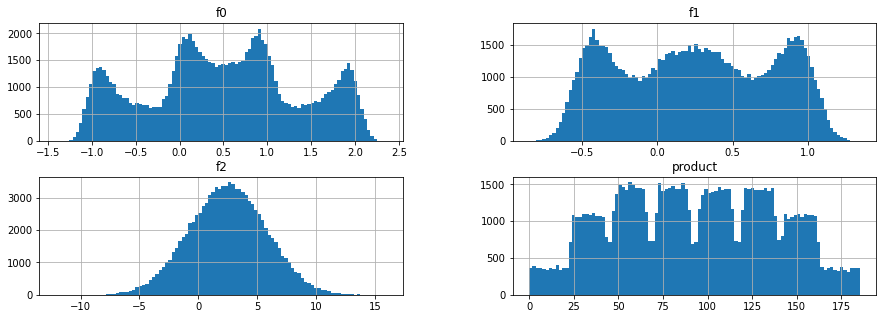

In [9]:
# посмотрим, как распределяются данные в признаках
df0.hist(bins=100, figsize=(15,5));

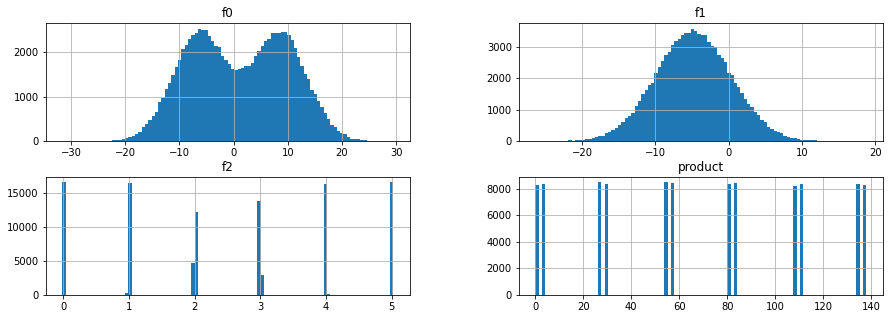

In [10]:
df1.hist(bins=100, figsize=(15,5));

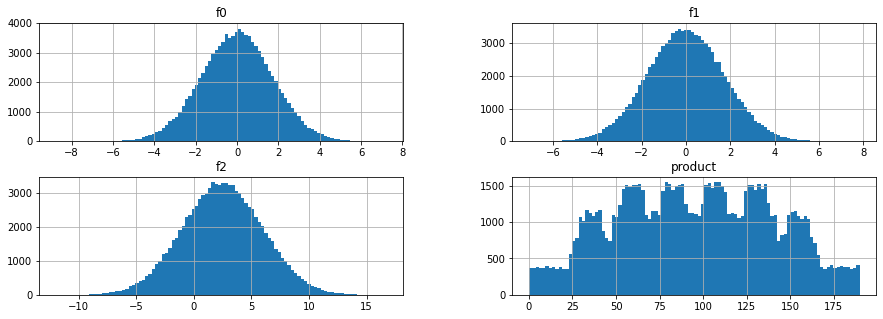

In [11]:
df2.hist(bins=100, figsize=(15,5));

***
Мы собираемся использовать линейную регрессию для предсказаний результатов. Для неё важно отсуствие корреляции между признаками, поэтому проверим на мультиколлинеарность, т.е. линиейную зависимость между признаками.
***

In [12]:
df0.corr(method='spearman').style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1.000000,-0.471379,-0.002739,0.128379
f1,-0.471379,1.000000,0.001440,-0.181136
f2,-0.002739,0.001440,1.000000,0.486370
product,0.128379,-0.181136,0.486370,1.000000


In [13]:
df1.corr(method='spearman').style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1.000000,0.182247,-0.002024,-0.122901
f1,0.182247,1.000000,-0.003674,-0.033906
f2,-0.002024,-0.003674,1.000000,0.975604
product,-0.122901,-0.033906,0.975604,1.000000


In [14]:
df2.corr(method='spearman').style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1.000000,0.002471,0.000046,-0.002453
f1,0.002471,1.000000,0.000349,-0.001508
f2,0.000046,0.000349,1.000000,0.448459
product,-0.002453,-0.001508,0.448459,1.000000


***
**Вывод по разделу**:

С данными на первый взгяд всё в порядке, в них нет явных дубликатов или пропусков. Обнаружили и удалили повторяющиеся `id` с разными количественными признаками, всего таких данных было 0.1-0.4%. На гистограммах видим как нормальное, бимодальное так и мультиммодальное распределение среди признаков.

Отметим, что на первом участке (`df1`) в признаке `f3` ступенчатое распределние значений, как будто они категориальные, а также все признаки выше нуля, в то время как значения аналогичного признака на других участках распредлены нормально и принимают как положительные, так и отрицательные значения. Аналогичная категориальность и в столбце `product`. 

Мультиколлинеарности в данных нет, зато есть корреляция на первом участке (`df1`) между признаком `f3`и целевым показателем `product`, она очень высокая положительная.
На остальных участках аналогичная корреляция, её можно оценить как слабую положительную.
***

## Обучение и проверка модели

Для каждого региона алгоритм выглядит так:
* Разбивка данных на обучающую и валидационную выборки в соотношении 75:25;
* Обучение модели и предсказания на валидационной выборке;
* Сохранение предсказаний и правильных ответов на валидационной выборке;
* Вывод на экран средних запасов предсказанного сырья и RMSE модели;

В конце раздела анализ всех результатов.

### Регион 0

In [15]:
# объявление переменных: с признаками и целевым признаком
features0 = df0.drop(['id', 'product'], axis=1)
target0 = df0['product']

In [16]:
# разделение исходных данных на две выборки: обучающую и валидационную
features_train0, features_valid0, target_train0, target_valid0 = \
train_test_split(features0, target0, test_size=0.25, random_state=1)

In [17]:
# соотношение выборок по объему
print(f"train = {100*len(features_train0)/len(df0):.4f}%")
print(f"val = {100*len(features_valid0)/len(df0):.4f}%")

train = 74.9995%
val = 25.0005%


In [18]:
model0 = LinearRegression()
model0.fit(features_train0, target_train0)
predicted_valid0 = model0.predict(features_valid0)
rmse0 = mean_squared_error(target_valid0, predicted_valid0, squared=False)
predicted_deposits0 = predicted_valid0.mean()

In [19]:
print('Регион 0')
print(f'RMSE = {rmse0:.3f}')
print(f'Средние запасы = {predicted_deposits0:.3f}')

Регион 0
RMSE = 37.527
Средние запасы = 92.546


### Регион 1

In [20]:
# объявление переменных: с признаками и целевым признаком
features1 = df1.drop(['id', 'product'], axis=1)
target1 = df1['product']

In [21]:
# разделение исходных данных на две выборки: обучающую и валидационную
features_train1, features_valid1, target_train1, target_valid1 = \
train_test_split(features1, target1, test_size=0.25, random_state=1)

In [22]:
# соотношение выборок по объему
print(f"train = {100*len(features_train1)/len(df1):.4f}%")
print(f"val = {100*len(features_valid1)/len(df1):.4f}%")

train = 75.0000%
val = 25.0000%


In [23]:
model1 = LinearRegression()
model1.fit(features_train1, target_train1)
predicted_valid1 = model1.predict(features_valid1)
rmse1 = mean_squared_error(target_valid1, predicted_valid1, squared=False)
predicted_deposits1 = predicted_valid1.mean()

In [24]:
print('Регион 1')
print(f'RMSE = {rmse1:.3f}')
print(f'Средние запасы = {predicted_deposits1:.3f}')

Регион 1
RMSE = 0.890
Средние запасы = 68.849


### Регион 2

In [25]:
# объявление переменных: с признаками и целевым признаком
features2 = df2.drop(['id', 'product'], axis=1)
target2 = df2['product']

In [26]:
# разделение исходных данных на две выборки: обучающую и валидационную
features_train2, features_valid2, target_train2, target_valid2 = \
train_test_split(features2, target2, test_size=0.25, random_state=1)

In [27]:
# соотношение выборок по объему
print(f"train = {100*len(features_train2)/len(df2):.4f}%")
print(f"val = {100*len(features_valid2)/len(df2):.4f}%")

train = 75.0000%
val = 25.0000%


In [28]:
model2 = LinearRegression()
model2.fit(features_train2, target_train2)
predicted_valid2 = model2.predict(features_valid2)
rmse2 = mean_squared_error(target_valid2, predicted_valid2, squared=False)
predicted_deposits2 = predicted_valid2.mean()

In [29]:
print('Регион 2')
print(f'RMSE = {rmse2:.3f}')
print(f'Средние запасы = {predicted_deposits2:.3f}')

Регион 2
RMSE = 39.984
Средние запасы = 94.967


In [30]:
print('Регион 0')
print(f'RMSE = {rmse0:.3f}')
print(f'Средние запасы = {predicted_deposits0:.3f}')
print('*'*25)
print('Регион 1')
print(f'RMSE = {rmse1:.3f}')
print(f'Средние запасы = {predicted_deposits1:.3f}')
print('*'*25)
print('Регион 2')
print(f'RMSE = {rmse2:.3f}')
print(f'Средние запасы = {predicted_deposits2:.3f}')

Регион 0
RMSE = 37.527
Средние запасы = 92.546
*************************
Регион 1
RMSE = 0.890
Средние запасы = 68.849
*************************
Регион 2
RMSE = 39.984
Средние запасы = 94.967


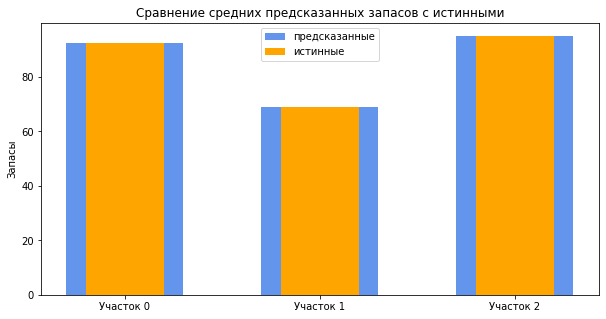

In [31]:
# сравним предсказанные и истинные средние значения в регионах
data1 = {'Участок 0':predicted_deposits0, 'Участок 1':predicted_deposits1, 'Участок 2':predicted_deposits2}
site1 = list(data1.keys())
values1 = list(data1.values())
data0 = {'Участок 0':target_valid0.mean(), 'Участок 1':target_valid1.mean(), 'Участок 2':target_valid2.mean()}
site0 = list(data0.keys())
values0 = list(data0.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(site1, values1, color ='cornflowerblue',
        width = 0.6, label = 'предсказанные')
plt.bar(site0, values0, color ='orange',
        width = 0.4, label = 'истинные')
plt.ylabel('Запасы')
plt.title('Сравнение средних предсказанных запасов с истинными')
plt.legend(loc = 'best')
plt.show()

***
**Вывод по разделу**:

Регион 0: средняя ошибка, средние запасы предсказанного сырья;

Регион 1: *самая маленькая ошибка*, самые низкие запасы предсказанного сырья;

Регион 2: самая большая ошибка, *самые высокие запасы предсказанного сырья*;

Средние предсказанных запасов практически идентичны истинным средним по каждому участку.
***

## Подготовка к расчёту прибыли

In [32]:
# все ключевые значения для расчётов сохраним в отдельных переменных
budget = 10000000000
points = 500
best_points = 200
operating_profit_per_barrel = 450000

In [33]:
# рассчитаем достаточный объём сырья для безубыточной разработки двухсот новых скважины
break_even = budget/operating_profit_per_barrel/best_points
print('Достаточный объём сырья для безубыточной разработки новой скважины: ')
print(f'{break_even:.3f} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины: 
111.111 тыс. баррелей


In [34]:
# cравним полученный объём сырья со средним запасом в каждом регионе
print(f'разница с регионом 0: {100*(1-break_even/target_valid0.mean()):.2f}%')
print(f'разница с регионом 1: {100*(1-break_even/target_valid1.mean()):.2f}%')
print(f'разница с регионом 2: {100*(1-break_even/target_valid2.mean()):.2f}%')

разница с регионом 0: -20.39%
разница с регионом 1: -61.38%
разница с регионом 2: -16.89%


***
**Вывод**:

По нашим расчётам, точка безубыточности для разработки двухсот новых скважин равна 111.1 тыс. баррелей для одной скважины. Это как минимум на 17% больше средних запасов по регионам.
***

## Расчёт прибыли и рисков 

### Расчёт прибыли по выбранным скважинам

In [35]:
# функция расчёта прибыли
def profit (target, predicted):
    probs_sorted = pd.Series(predicted).sort_values(ascending=False)
    selected = target.reset_index(drop = True)[probs_sorted.index][:best_points]

    return round(selected.sum()*operating_profit_per_barrel - budget)

In [37]:
print('Прибыль с топ-200 скважин региона 0:', profit(target_valid0, predicted_valid0))
print('Прибыль с топ-200 скважин региона 1:', profit(target_valid1, predicted_valid1))
print('Прибыль с топ-200 скважин региона 2:', profit(target_valid2, predicted_valid2))

Прибыль с топ-200 скважин региона 0: 3102100275
Прибыль с топ-200 скважин региона 1: 2415086697
Прибыль с топ-200 скважин региона 2: 2664835424


***
**Вывод**: По нашим расчётам, все ригионы прибыльные, а самый прибыльный регион 0: 3102100275.
***

### Расчёт рисков для каждого региона

In [78]:
state = np.random.RandomState(12345)
def confidence_interval(target, predicted, site):
    samples = []
    preds = pd.Series(predicted)
    for i in range(1000):
        sample = preds.sample(n=points, replace=True, random_state=state)
        samples.append(profit(target,sample))
    samples = pd.Series(samples)
    print('Средняя прибыль:', round(samples.mean()))
    print(f'Риск убытков: {100*(samples.apply(lambda x: x < 0).mean()):.2f}%')
    samples.plot.density(figsize=(10, 5), label=site, alpha = 0.75) 
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.925)
    return round(lower), round(upper)

In [39]:
site0 = 'Участок 0'
site1 = 'Участок 1'
site2 = 'Участок 2'

Участок 0
Средняя прибыль: 431182835
Риск убытков: 5.00%
95%-й доверительный интервал: (-76134193, 781415390)
**********************************************************************
Участок 1
Средняя прибыль: 433335574
Риск убытков: 2.10%
95%-й доверительный интервал: (9676089, 738230510)
**********************************************************************
Участок 2
Средняя прибыль: 366643286
Риск убытков: 8.70%
95%-й доверительный интервал: (-168169597, 748848567)
**********************************************************************


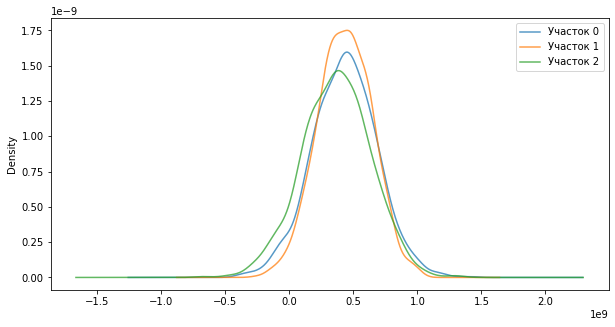

In [79]:
print('Участок 0')
print('95%-й доверительный интервал:', confidence_interval(target_valid0, predicted_valid0, site0))
print(70*'*')
print('Участок 1')
print('95%-й доверительный интервал:', confidence_interval(target_valid1, predicted_valid1, site1))
print(70*'*')
print('Участок 2')
print('95%-й доверительный интервал:', confidence_interval(target_valid2, predicted_valid2, site2))
print(70*'*')
plt.legend();

## Общий вывод

Целью исследования был выбор региона с наибольшей прибылью и наименьшими рисками. Приемлимый риск по условиям задачи: 2.5%.

По результатам исследования все регионы потенциально приыбльные, но лишь один из участков подходит по критериям риска: на участке 1 **риск убытка равен 2.0%**, так же в этом регионе наивысшая средняя прибыль.

Таким образом, наш выбор это:

**Участок 1**:
* Средняя прибыль: 446381118
* Риск убытков: 2.00%
* 95%-й доверительный интервал: (41701228, 736845009)